## Importe

- **pandas** wird zum Einlesen der Daten benötigt. Außerdem ermöglicht die Datenstruktur **DataFrame** viele Möglichkeiten, um Daten zu filtern und zu transformieren.
- **numpy** wird von **pandas** benötigt.
- **matplotlib.pyplot** stellt eine Schnittstelle für das Plotten mit **matplotlib** zur Verfügung.
- **characterization_loader** ist ein selbst geschriebenes Modul, um die einzelnen Datensätze aus den csv-Dateien auszulesen und in ein gemeinsammes **DataFrame** zu vereinen.
- ``%matplotlib inline`` sorgt dafür, dass diagramme direkt im Browser angezeigt werden.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import characterization_loader as loader
%matplotlib inline

## Daten laden

Die Daten wurden mit Hilfe von ``CSV-Datein der Charakterisierung.ipynb`` nach Parametern der Charakterisierung sortiert. Ein Datensatz wird mit der folgenden Zeile Code importiert.

In [2]:
raw_data = loader.load_dataframe(path='data/characterisation_Li,32,poly3')
#raw_data = loader.load_dataframe(path='data/characterisation_Li,16,poly3')
#raw_data = loader.load_dataframe(path='data/characterisation_Limit,32,poly3')
#raw_data = loader.load_dataframe(path='data/characterisation_Limit,16,poly3')
print('Anzahl der Zeilen im Datensatz:', len(raw_data))

Anzahl der Zeilen im Datensatz: 48133


## Spektren pro Charakterisierung

Wir möchten herausfinden, wie viele Spektren in den verschiedenen Datensätzen enthalten sind. Da sich ein Datensatz mit Hilfe von *Comment* und *QSinK7* eindeutig identifizieren lässt, nutzen wir diese Kategorien zur Gruppierung. Anschließend wird für jede Gruppe die Anzahl der Dateien bestimmt (``File.max()``). Mit Hilfe von **Counter** kann man herausfinden, wie häufig ein Wert in einem Datensatz vorkommt. Da Histogramm zeigt die verteilung grafisch.

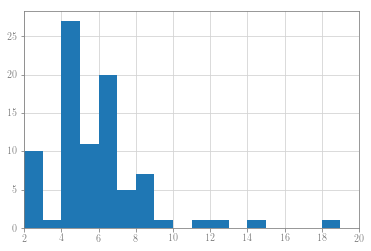

3: 10
4: 1
5: 27
6: 11
7: 20
8: 5
9: 7
10: 1
12: 1
13: 1
15: 1
19: 1


In [3]:
from collections import Counter
files_per_dataset = Counter(raw_data.groupby(['Comment', 'QSinK7']).File.max())
xs = [val - 0.5 for val in files_per_dataset.keys()]
plt.bar(xs, files_per_dataset.values(), width=1)
plt.xlim(min(files_per_dataset.keys()) - 1, max(files_per_dataset.keys()) + 1)
plt.show()
for key in sorted(files_per_dataset):
    print('{}: {}'.format(key, files_per_dataset[key]))

In [4]:
print('Anzahl der Datensätze:', sum(files_per_dataset))

Anzahl der Datensätze: 111


## Pivot-Tabelle zur mittleren Breite

Mit **pandas** kann man Pivot-Tabellen erzeugen. In diesem Beispiel wird gezeigt, wie die mittlere Breite von SpecMag und QSinK7 abhängt. Vorher werden alle Datensätze herausgefiltert, die *ZLP* enthalten, da diese die mittlere Breite verfälschen würden.

In [5]:
non_zlp = raw_data[raw_data['Comment'].str.find('ZLP') == -1]
mean_width = non_zlp.pivot_table('width', index='QSinK7', columns='SpecMag', aggfunc=np.mean).fillna('')
mean_width

SpecMag,100.0,125.0,163.0,200.0,250.0,315.0
QSinK7,,,,,,
-42.0,524.265,,,,,
-40.0,,689.106,,,,
-36.0,460.084,,,,,
-35.0,,606.359,,,,
-33.0,,566.473,,,,
-32.0,,557.362,,,,
-30.0,383.858,537.014,,,1057.68,
-26.0,,462.863,558.969,,,
-25.0,,455.852,,,,


Dies dient als Spickzettel, damit ich weiß, wie die einzelnen Spalten exakt geschrieben werden:

In [6]:
raw_data.columns

Index(['y-position', 'y-error', 'x-position', 'x-error', 'left-position',
       'left-error', 'right-position', 'right-error', 'width', 'width-error',
       'threshold', 'fitted-x-position', 'fitted-left-position',
       'fitted-right-position', 'File', 'SpecMag', 'QSinK7', 'Comment',
       'File_Count', 'Threshold', 'Step_Size', 'Left_Offset', 'Right_Offset',
       'Polynomial_Order'],
      dtype='object')

## Daten filtern und plotten

Mit Hilfe diverse Funktionen wird der Datensatz gefiltert und geplottet. Der Filter dient dazu, das nur bestimmte Parameter beim Plotten berücksichtigt werden. Dadurch, dass ich schon vor dem Einlesen die Daten nach den Parametern sortiere, wird ``filter_dict`` im Moment nicht mehr genutzt.

Geplottet werden zwei Arten von Diagrammen. Das erste trägt die mittlere Breite gegen die Position des Spektrums auf und resultiert in einen parabelförmigen Verlauf. Beim zweiten Diagramm wird die mittlere Breite gegen QSinK7 aufgetragen. Es ergeben sich zwei unabhängige lineare Verläufe, für negative und positive Werte von QSinK7.

In [7]:
def get_data(sm, filter_dict=None, zlp=False):
    data_filtered = raw_data[raw_data['SpecMag'] == sm]
    if filter_dict:
        for key, value in filter_dict.items():
            data_filtered = data_filtered[data_filtered[key] == value]
    if not zlp:
        data_filtered = data_filtered[data_filtered['Comment'].str.find('ZLP') == -1]
    data_grouped = data_filtered[['x-position',
                                  'Comment',
                                  'File',
                                  'width',
                                  'QSinK7'
                                 ]].groupby(['QSinK7', 'Comment', 'File']).mean()
    data_grouped['x-error'] = data_filtered[['x-position',
                                             'Comment',
                                             'File',
                                             'width',
                                             'QSinK7'
                                            ]].groupby(['QSinK7', 'Comment', 'File']).std()['x-position']
    data_grouped['y-error'] = data_filtered[['x-position',
                                             'Comment',
                                             'File',
                                             'width',
                                             'QSinK7'
                                            ]].groupby(['QSinK7', 'Comment', 'File']).std()['width']
    return data_grouped

def plot_width_vs_pos(dataframe):
    import matplotlib.colors as colors
    import matplotlib.cm as cmx
    import matplotlib.patches as mpatches
    patches = []
    cmap = cm = plt.get_cmap('Vega20b')
    # Die Colormap benötigt so viele Stufen, wie es unterschiedliche QSinK7-Werte im Datensatz gibt.
    cNorm  = colors.Normalize(vmin=0, vmax=len(dataframe.groupby(level='QSinK7'))-1)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)

    index = 0

    plt.figure(figsize=(8, 15))
    # Mit Hilfe der Methode groupby() kann man über die Multiindizes iterieren.
    # Es können auch mehrere Indizes als Liste an den Parameter 'level' übergebenwerden.
    for sm, data in dataframe.groupby(level='QSinK7'):
        color = scalarMap.to_rgba(index)
        weight = np.sqrt((1 / data['x-position'])**2 + (1 / data['width'])**2)
        poly_params = np.polyfit(x=data['x-position'], y=data['width'], deg=2, w=weight)
        x_fit = np.linspace(0, 4097, 1000)
        y_fit = np.polyval(x=x_fit, p=poly_params)
        # Für das Label wird QSinK7 in ein int umgewandelt, da so die unnötige Nachkommastelle verschwindet.
        plt.plot(x_fit, y_fit, label='', c=color)
        patches.append(mpatches.Patch(color=color, label='{} %'.format(int(sm),)))
        # Damit die Datenpunkte nicht so dominant wirken wird Tranzparanz (alpha) verwendet.
        # Durch ls='none' werden die Linien entfernt, welche die Datenpunkte ansonsten verbinden.
        # Wird das Label of None (Alternative: leerere String '') gesetzt, erscheint es nicht in der Legende.
        plt.errorbar(x=data['x-position'],
                     y=data['width'],
                     xerr=data['x-error'],
                     yerr=data['y-error'],
                     alpha=0.25,
                     ls='none',
                     capsize=4,
                     capthick=1,
                     label=None,
                     c=color)
        index += 1

    plt.xlim(0, 4096)
    plt.xticks(np.arange(0, 4097, 512))
    plt.xlabel('Position des Spektrums auf der Ortsachse [px]')
    plt.ylim(0, dataframe.width.max() * 1.1)
    plt.ylabel('Mittlere Breite des Spektrums [px]')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='QSinK7', handles=patches, fontsize = 'large')
    return plt.gcf()

def plot_width_vs_qsink7(dataframe, norm=False, fit_positiv=False):
    from sklearn.metrics import r2_score
    width = dataframe.groupby(level='QSinK7').mean().width
    width_stdv = dataframe.groupby(level='QSinK7').std().width * 2
    if norm:
        width /= 1050
        width_stdv /= 1050
    width_fit = width[width.index <= 0]
    params_line = np.polyfit(x=width_fit.index, y=width_fit, deg=1)
    def g(x):
        return np.polyval(params_line, x)
    x_low = width.index.min() - 5
    if fit_positiv:
        x_high = width.index.max() + 5
    else:
        x_high = 5
    x_fit = np.linspace(x_low, x_high, 100)
    y_fit = g(x_fit)
    r2 = r2_score(width_fit, g(width_fit.index))
    print('r² für den linearen Fit: %g' % (r2,))
    if fit_positiv:
        width_fit = width[width.index > 0]
        params_line = np.polyfit(x=width_fit.index, y=width_fit, deg=1)
        def g(x):
            return np.polyval(params_line, x)
        x_low = width.index.min() - 5
        x_high = width.index.max() + 5
        x_fit_positiv = np.linspace(x_low, x_high, 100)
        y_fit_positiv = g(x_fit)
        r2 = r2_score(width_fit, g(width_fit.index))
        print('r² für den linearen Fit: %g' % (r2,))
    plt.figure(figsize=(5, 4))
    plt.errorbar(x=width.index,
                 y=width,
                 yerr=width_stdv,
                 fmt='.',
                 capsize=4,
                 capthick=1
                )
    plt.plot(x_fit, y_fit)
    if fit_positiv:
        plt.plot(x_fit_positiv, y_fit_positiv)
    plt.xlim(x_low, x_high)
    plt.xlabel('QSinK7 [\%]')
    _, ymax = plt.ylim()
    plt.ylim(0, ymax)
    plt.ylabel('Mittlere Breite des Spektrums [px]')
    if norm:
        plt.ylabel('Relative Vergrößerung')
    return plt.gcf()

## ``SpecMag`` 125x
Es werden die Daten extrahiert, die bei SpecMag 125 aufgenommen wurden. Außerdem werden nur die Werte verwendet, die mit der Thresholding-Methode 'Li' ermittelt wurden.

Als zweites wird ein Datensatz erzeugt, der nur noch die relevanten Spalten enthält. Gleichzeitig werden alle Spalten bis auf 'QSinK7', 'Comment' und 'File' auf ihre Mittelwerte reduziert.

Zuletzt werden noch neue Spalten ergänzt, die aus der Standardabweichung der x-Position, sowie der Breite berechnete Unsicherheiten enthalten.

In [8]:
data_SM125 = get_data(sm=125, filter_dict={'Threshold': 'Li'})
'''
data_SM125 = get_data(sm=125, filter_list={'Threshold': 'Li'})\
    .append(get_data(sm=125, filter_list={'Threshold': 'Huang'}))
'''
len(data_SM125)

316

### Plotten
Das Diagramm soll die Breite der Spektren in Abhängigkeit vom QSinK7-Wert zeigen, wobei die Veränderung der Breite in Abhängigkeit von der x-Position dargestellt wird.

Da die einzelnen Werte relativ stark schwanken, wird ein Polynom 2ten Grades an die Daten angefittet. Zusätzlich sind jedoch noch die einzelnen Datenpunkte mit ihren Unsicherheiten zu sehen.

### Ergebnis

``SpecMag`` 125x wurde am ausgiebigsten untersucht, da sich diese Vergrößerung am besten für die Untersuchung der Chrom-Eisen-Schichtsystems eignet. Die L-Kanten von Chron und Eisen sind in einem Spektrum sichtbar. Außerdem kann man noch die K-Kante von Sauerstoff aufnehmen, die sich kurz vor den L-Kanten von Chrom befindet.

Das erste Diagramm zeigt, dass sich der Kurvenverlusf von einer nach unten geöffneten Parabel in eine nach oben geöffnete Parabel ändert, wenn man ``QSinK7`` weiter verringert. Bei etwa -33% verläuft die Kurve fast waagerecht. Positive Werte von ``QSinK7`` führen sehr schnell zu einer nach oben geöffneten Parabel. Mit +20% ist nur ein Wert ausgewertet worden. Es fällt die gringe Breite im Zentrum (bei 2048) auf, die vergleichbar ist mit ``QSinK7`` = -10%.

Im zweiten Diagramm ist die mittlere Breite gegen den Wert von ``QSinK7`` aufgetragen. Es ist eindeutig ein linearer Zusammenhang zu erkennen. Der Fit stimmt sehr gut mit den Datenpunkten überein ($r^2\approx1$). Die Werte sind im dritten Diagramm in relation zur Ortsauflösung im Abbildungsmodus dargestellt. Nur bei diesem ``SpecMag``-Wert wird dieses Diagramm gezeigt. Es lässt sich jedoch auch bei den anderen ``SpecMag``-Werten einfach erstellen, indem man den Aufruf von ``plot_width_vs_qsink7()`` um den optionalen Parameter ``norm=True`` ergänzt.

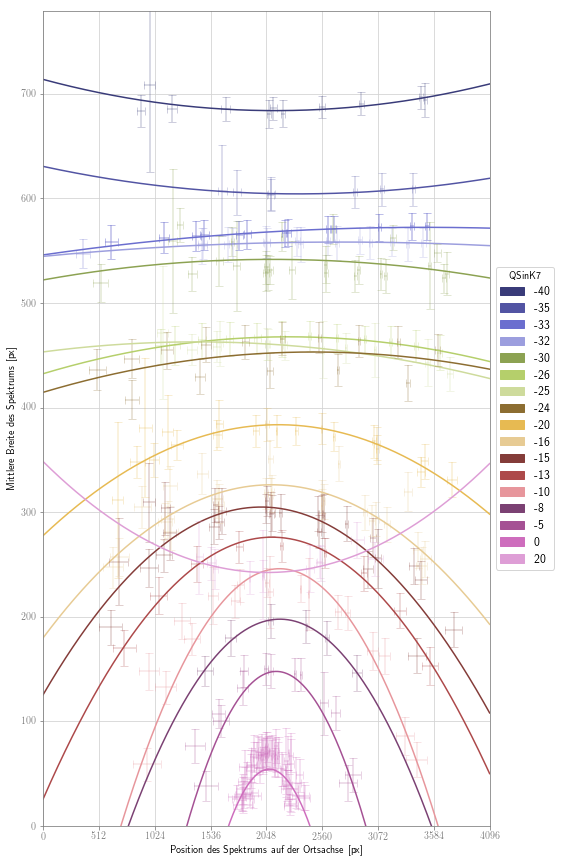

In [9]:
fig_width_vs_pos_SM125 = plot_width_vs_pos(data_SM125)
fig_width_vs_pos_SM125.savefig('Bilder/QSinK7_SM125_width-vs-pos.pdf')

r² für den linearen Fit: 0.995996


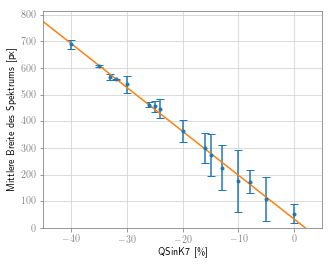

In [10]:
fig_width_vs_qsink7_SM125 = plot_width_vs_qsink7(data_SM125)
fig_width_vs_qsink7_SM125.savefig('Bilder/QSinK7_SM125_width-vs-QSinK7.pdf')

r² für den linearen Fit: 0.995996


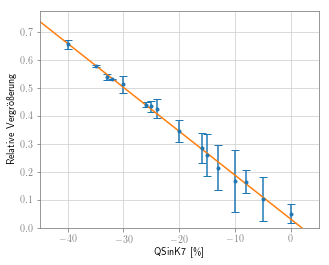

In [11]:
fig_width_vs_qsink7_SM125_norm = plot_width_vs_qsink7(data_SM125, norm=True)
fig_width_vs_qsink7_SM125_norm.savefig('Bilder/QSinK7_SM125_width-vs-QSinK7_norm.pdf')

## ``SpecMag`` 315x

Diese Vergrößerung wird in meiner Dissertation genauer betrachtet, weshalb an dieser Stelle nicht weiter darauf eingegangen wird.

In [12]:
data_SM315 = get_data(sm=315)
len(data_SM315)

53

### Plotten

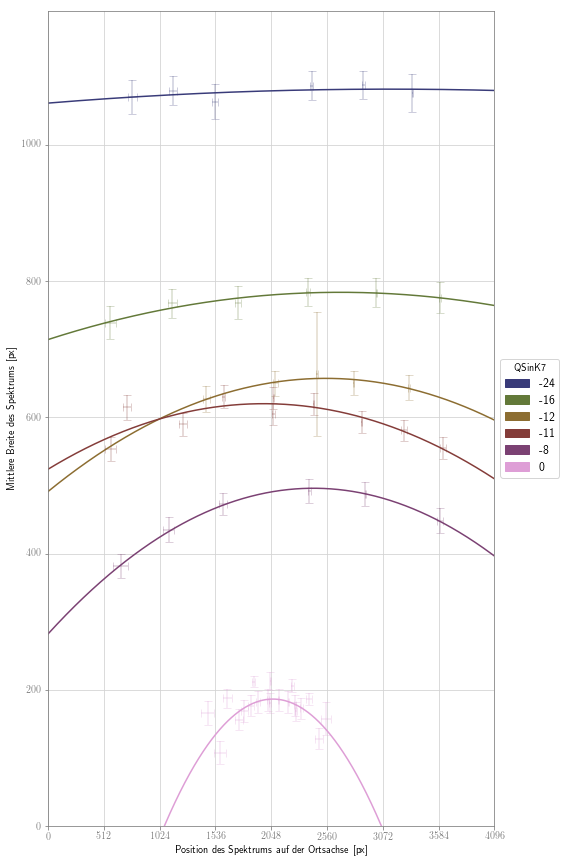

In [13]:
fig_width_vs_pos_SM315 = plot_width_vs_pos(data_SM315)
fig_width_vs_pos_SM315.savefig('Bilder/QSinK7_SM315_width-vs-pos.pdf')

r² für den linearen Fit: 0.997698


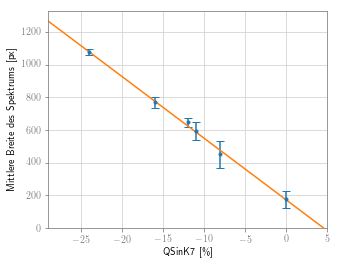

In [14]:
fig_width_vs_qsink7_SM315 = plot_width_vs_qsink7(data_SM315)
fig_width_vs_qsink7_SM315.savefig('Bilder/QSinK7_SM315_width-vs-QSinK7.pdf')

## ``SpecMag`` 100x

Diese Vergrößerung resultiert in ein Energieintervall von 270 eV. Jedoch ist die laterale Ausdehnung sehr gering. Bei ``QSinK7`` = 0 % beträgt die maximale Breite der Filtereintrittsblende etwa 50 Pixel, was im Vergleich zum Abbildungsmodus eine Verkleinerung um den Faktor 21 darstellt. Diese Spektrumsvergrößerung wurde deshalb nur wenig untersucht.

In [15]:
data_SM100 = get_data(sm=100)
len(data_SM100)

22

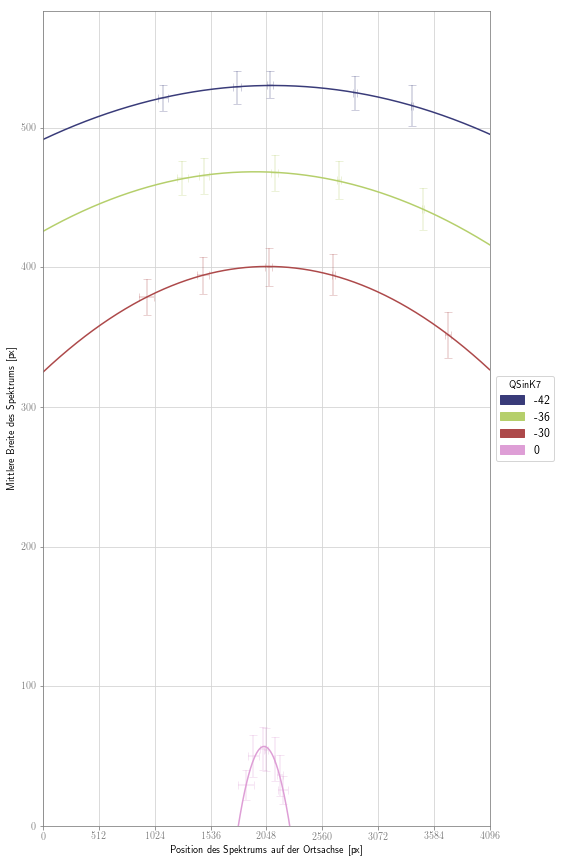

In [16]:
fig_width_vs_pos_SM100 = plot_width_vs_pos(data_SM100)
fig_width_vs_pos_SM100.savefig('Bilder/QSinK7_SM100_width-vs-pos.pdf')

r² für den linearen Fit: 0.999801


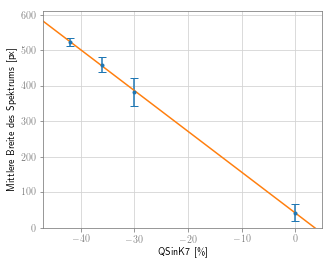

In [17]:
fig_width_vs_qsink7_SM100 = plot_width_vs_qsink7(data_SM100)
fig_width_vs_qsink7_SM100.savefig('Bilder/QSinK7_SM100_width-vs-QSinK7.pdf')

## ``SpecMag`` 163x

An diesem ``SpecMag``-Wert wurden die Auswirkungen von Binning und Belichtungszeit auf die Charakterisierung untersucht. Dabei wurde nur der ``QSinK7``-Wert -26% genutzt. Für die hier genutzte Auswertung sind die datensätze nicht geeignet.

In [18]:
data_SM163 = get_data(sm=163)
len(data_SM163)

33

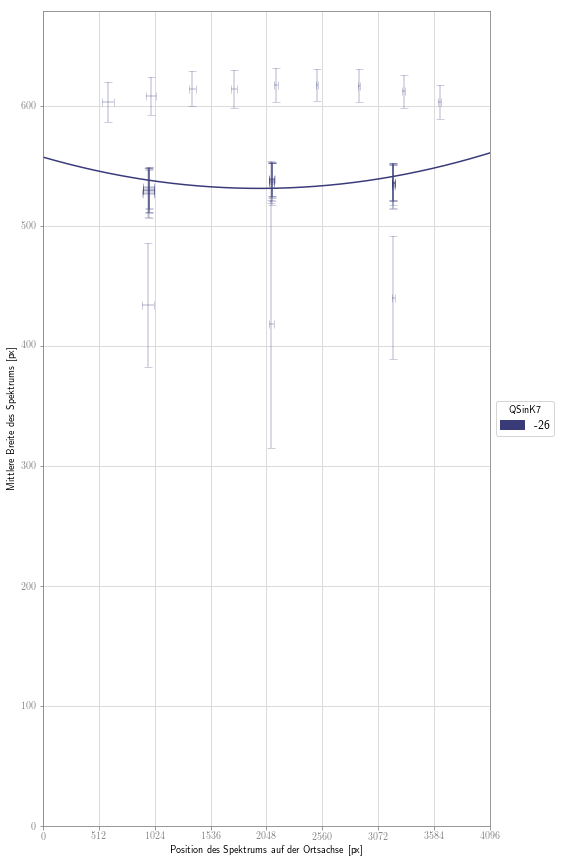

In [19]:
fig_width_vs_pos_SM163 = plot_width_vs_pos(data_SM163)

r² für den linearen Fit: 0


/home/michael/git/Dissertation-github/Jupyter-Notebooks/.venv/lib/python3.6/site-packages/ipykernel/__main__.py:83: RankWarning: Polyfit may be poorly conditioned


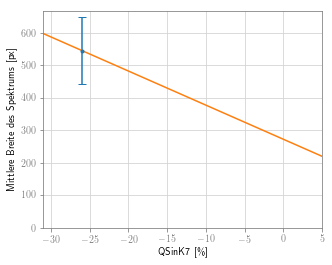

In [20]:
fig_width_vs_qsink7_SM163 = plot_width_vs_qsink7(data_SM163)

## ``SpecMag`` 200x

Bei ``SpecMag`` 200x erhält man ein Energieintervall von 123 eV. Damit ist diese Spektrumsvergrößerung nicht gut für die Referenzprobe -- das Eisen-Chrom-Schichtsystem -- geeignet, da der Abstand der L-Kanten 133 eV  beträgt. Es wurden dennoch ein paar Messungen zur Charakterisierung der Verzeichnung durchgeführt, um einen linearen Zusammenhang zwischen der Breite des Spektrums und dem gewählten Wert von ``QSinK7`` zu zeigen. In der ersten Abbildung lässt sich dieser Zusammenhang an den gleich großen Abständen der Kurven erkennen, da auch ``QSinK7`` jeweils in -3%-Schritten reduziert wurde. Bei den positiven Werten von ``QSinK7`` ist die Schrittweite viermal so groß, weshalb dort der lineare Zusammenhang erst durch Zuhilfenahme der zweiten Abbildung sehr gut ersichtlich wird. Dies ist der einzige ``SpecMag``-Wert bei dem ausreichend positive ``QSinK7``-Werte untersucht wurden.

In [21]:
data_SM200 = get_data(sm=200, zlp=True)
len(data_SM200)

89

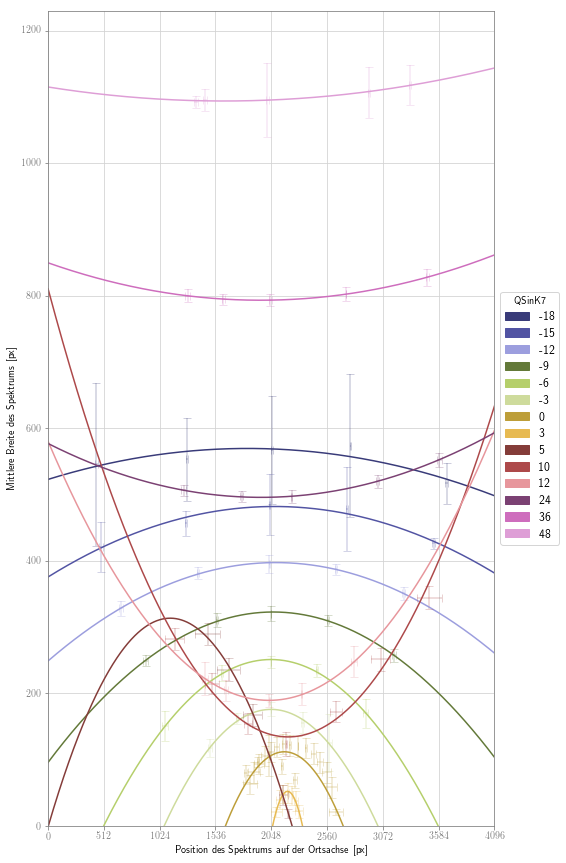

In [22]:
fig_width_vs_pos_SM200 = plot_width_vs_pos(data_SM200)
fig_width_vs_pos_SM200.savefig('Bilder/QSinK7_SM200_width-vs-pos.pdf')

r² für den linearen Fit: 0.991487
r² für den linearen Fit: 0.993539


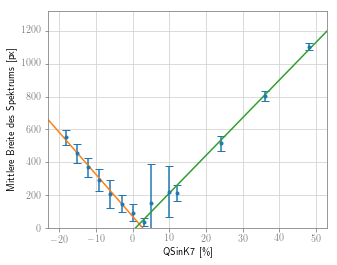

In [23]:
fig_width_vs_qsink7_SM200 = plot_width_vs_qsink7(data_SM200, fit_positiv=True)
fig_width_vs_qsink7_SM200.savefig('Bilder/QSinK7_SM200_width-vs-QSinK7.pdf')

## ``SpecMag`` 250x

Zu diesem ``SpecMag``-Wert exsitieren nur zwei Datensätze, die wenige Informationen liefern. Möchte man nur ein kleines Energieintervall von 100 eV mit SR-EELS untersuchen, so eignet sich die Kombination aus ``SpecMag`` 250x und ``QSinK7`` = -30% sehr gut, da man eine Ortsauflösung erhält, die mit dem Abbildungsmodus vergleichbar ist.

In [24]:
data_SM250 = get_data(sm=250)
len(data_SM250)

12

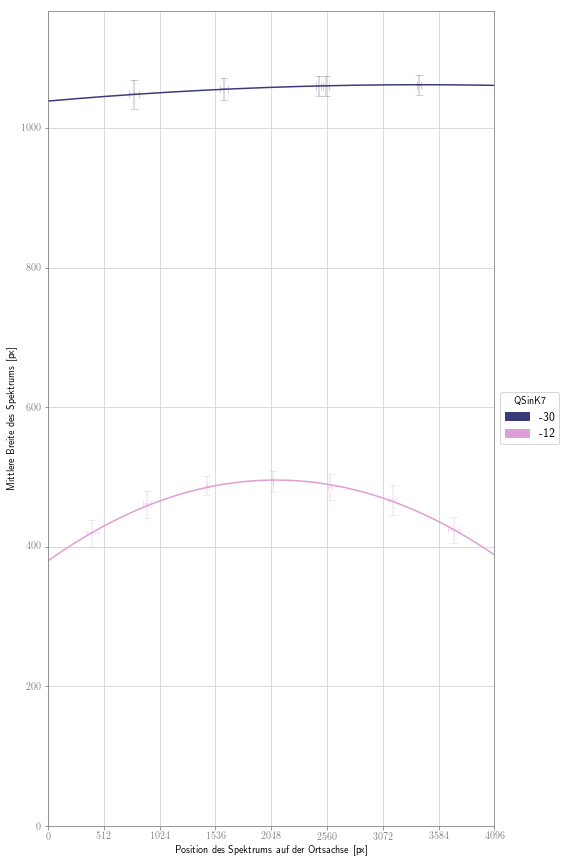

In [25]:
fig_width_vs_pos_SM250 = plot_width_vs_pos(data_SM250)

r² für den linearen Fit: 1


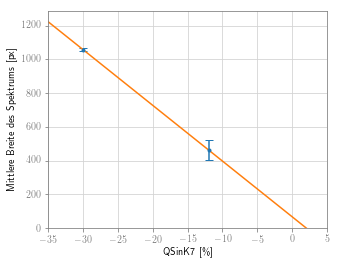

In [26]:
fig_width_vs_qsink7_SM250 = plot_width_vs_qsink7(data_SM250)

## Vergleich von SM125 und SM315

In [27]:
data_SM125_m33 = data_SM125.loc[-33.0]
data_SM315_m11 = data_SM315.loc[-11.0]

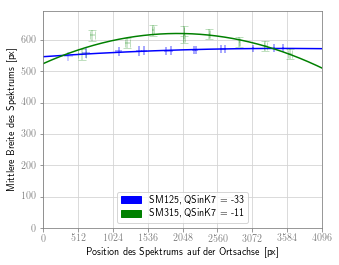

In [28]:
import matplotlib.patches as mpatches
plt.figure(figsize=(5, 4))
weight_SM125 = np.sqrt((1 / data_SM125_m33['x-position'])**2 + (1 / data_SM125_m33['width'])**2)
weight_SM315 = np.sqrt((1 / data_SM315_m11['x-position'])**2 + (1 / data_SM315_m11['width'])**2)
poly_params_SM125 = np.polyfit(x=data_SM125_m33['x-position'], y=data_SM125_m33['width'], deg=2, w=weight_SM125)
poly_params_SM315 = np.polyfit(x=data_SM315_m11['x-position'], y=data_SM315_m11['width'], deg=2, w=weight_SM315)
x_fit = np.linspace(0, 4097, 1000)
y_fit_SM125 = np.polyval(x=x_fit, p=poly_params_SM125)
y_fit_SM315 = np.polyval(x=x_fit, p=poly_params_SM315)
plt.plot(x_fit, y_fit_SM125, label=None, c='b')
plt.plot(x_fit, y_fit_SM315, label=None, c='g')
plt.errorbar(x=data_SM125_m33['x-position'], y=data_SM125_m33['width'], 
             xerr=data_SM125_m33['x-error'], yerr=data_SM125_m33['y-error'],
             alpha=0.25, ls='none', label=None, c='b'
            )
plt.errorbar(x=data_SM315_m11['x-position'], y=data_SM315_m11['width'],
             xerr=data_SM315_m11['x-error'], yerr=data_SM315_m11['y-error'],
             alpha=0.25,
             ls='none',
             capsize=4,
             capthick=1,
             label=None,
             c='g'
            )


plt.xlim(0, 4096)
plt.xticks(np.arange(0, 4097, 512))
plt.xlabel('Position des Spektrums auf der Ortsachse [px]')
plt.ylim(0, max(data_SM125_m33.width.max(), data_SM315_m11.width.max()) * 1.1)
plt.ylabel('Mittlere Breite des Spektrums [px]')
patches = [mpatches.Patch(color='b', label='SM125, QSinK7 = -33 %'),
           mpatches.Patch(color='g', label='SM315, QSinK7 = -11 %')
          ]
legend = plt.legend(loc='lower center', handles=patches)
plt.savefig('Bilder/QSinK7_Vergleich_SM125_SM315.pdf')

## Vergrößerung bei SM125 mit QSinK7 = -33%

In [29]:
data_SM315.loc[0.0].width.max()

213.03225806451613

In [30]:
data_SM125.loc[-33.0].width.max()

573.20161290322585

In [31]:
data_SM125.loc[-33.0].width.max() / data_SM315.loc[0.0].width.max()

2.6906798909751668